# Task 2: Predicting customer buying behaviour
## 6. Modeling and evaluation

## Import libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report


import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

## Load the data

In [55]:
x = pd.read_pickle("x_bal.pickle")
y = pd.read_pickle("y_bal.pickle")

## Modeling

#### Split train and test sets

In [56]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Hyperparameter tuning using RandomSearchCV

In [36]:
pipe = Pipeline([('algorithm',RandomForestClassifier())])

grid = [{'algorithm': [LogisticRegression()],
         'algorithm__n_jobs': [-1],
         'algorithm__solver': ['saga'],
         'algorithm__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algorithm__C': [0,0.25,0.5,0.75,1]},
        
        {'algorithm': [RandomForestClassifier()],
         'algorithm__n_jobs': [-1],
         'algorithm__max_depth': [5,10,15],
         'algorithm__n_estimators': [50,100,200]},
        
        {'algorithm': [XGBClassifier()],
         'algorithm__n_jobs': [-1],
         'algorithm__verbosity': [0],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_depth': [5,10,20],
         'algorithm__reg_alpha': [0,0.1,0.5,1],
         'algorithm__reg_lambda': [0.01,0.1,1],
         'algorithm__n_estimators': [100,500,1000]},
        
        {'algorithm': [HistGradientBoostingClassifier()],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_iter': [50,100,200],
         'algorithm__max_depth': [5,10,20],
         'algorithm__min_samples_leaf': [500],
         'algorithm__scoring': ['roc_auc'],
         'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

In [37]:
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 5, 
                                   cv = 3, 
                                   scoring = 'roc_auc', 
                                   verbose = 0,
                                   n_jobs = -1)

modelo = random_search.fit(train_x,train_y)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo__verbosity,param_algoritmo__reg_lambda,param_algoritmo__reg_alpha,param_algoritmo__n_jobs,param_algoritmo__n_estimators,param_algoritmo__max_depth,param_algoritmo__learning_rate,param_algoritmo,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.55,0.08,0.14,0.09,NaN,NaN,NaN,-1,100,10,NaN,"RandomForestClassifier(max_depth=10, n_jobs=-1)","{'algoritmo__n_jobs': -1, 'algoritmo__n_estima...",0.77,0.75,0.76,0.76,0.01,1
0,5.24,0.10,0.08,0.01,0,0.10,1,-1,100,10,0.01,"XGBClassifier(base_score=None, booster=None, c...","{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.77,0.76,0.75,0.76,0.01,2
1,10.31,0.03,0.10,0.00,0,0.01,0.50,-1,500,5,0.10,"XGBClassifier(base_score=None, booster=None, c...","{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.75,0.75,0.74,0.75,0.00,3
4,2.09,0.19,0.03,0.00,0,0.01,0.10,-1,100,5,0.01,"XGBClassifier(base_score=None, booster=None, c...","{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.76,0.74,0.74,0.75,0.01,4
2,46.35,0.39,0.85,0.02,0,0.01,1,-1,1000,20,0.10,"XGBClassifier(base_score=None, booster=None, c...","{'algoritmo__verbosity': 0, 'algoritmo__reg_la...",0.73,0.72,0.72,0.72,0.01,5


#### Predict probablities

In [38]:
pred = modelo.best_estimator_.predict_proba(val_x)[:, 1]

#### Evaluate model

In [39]:
roc_auc_score(val_y, pred)

0.7511144012734199

In [60]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo', RandomForestClassifier(max_depth=10, n_jobs=-1))])

#### The feature importances are the following

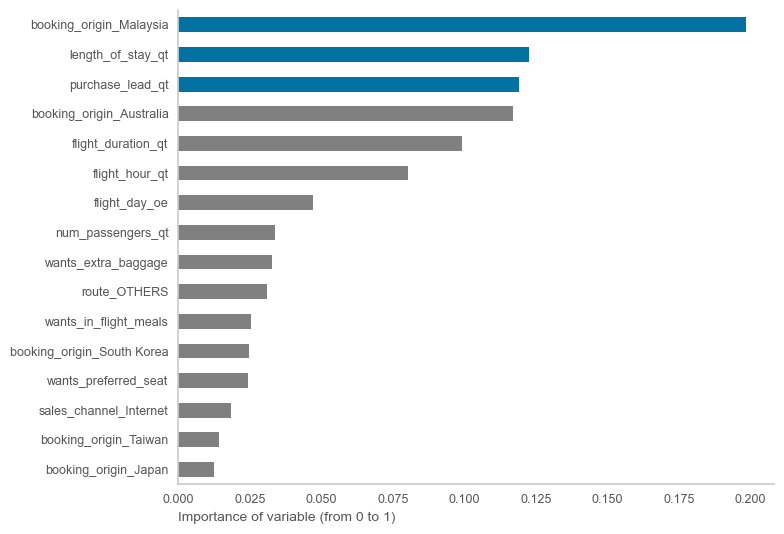

In [65]:
temp = pd.Series(modelo.best_estimator_[0].feature_importances_, index=train_x.columns).sort_values(ascending=True)[-30:]
colors = ["gray"]*(len(temp) - 3) + ["b"]*3

temp.plot(kind="barh", color=colors)

plt.xticks(size=9, color="#555555")
plt.yticks(size=9, color="#555555")
plt.xticks(rotation=0)
# plt.ylabel("Most important variables", loc="left",size=12, color="#555555")
plt.xlabel("Importance of variable (from 0 to 1)", loc="left",size=10, color="#555555");

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

plt.grid(False)
plt.tight_layout();